Epoch 001: Train Loss = 0.158042, Test Loss = 0.032681
Epoch 002: Train Loss = 0.023814, Test Loss = 0.016303
Epoch 003: Train Loss = 0.014071, Test Loss = 0.010327
Epoch 004: Train Loss = 0.009784, Test Loss = 0.009050
Epoch 005: Train Loss = 0.007454, Test Loss = 0.006544
Epoch 006: Train Loss = 0.005921, Test Loss = 0.005827
Epoch 007: Train Loss = 0.004934, Test Loss = 0.004829
Epoch 008: Train Loss = 0.004181, Test Loss = 0.004522
Epoch 009: Train Loss = 0.003807, Test Loss = 0.003353
Epoch 010: Train Loss = 0.003281, Test Loss = 0.003285
Epoch 011: Train Loss = 0.002957, Test Loss = 0.002880
Epoch 012: Train Loss = 0.002586, Test Loss = 0.002731
Epoch 013: Train Loss = 0.002283, Test Loss = 0.002586
Epoch 014: Train Loss = 0.002195, Test Loss = 0.002441
Epoch 015: Train Loss = 0.002009, Test Loss = 0.002517
Epoch 016: Train Loss = 0.001902, Test Loss = 0.002074
Epoch 017: Train Loss = 0.001590, Test Loss = 0.002069
Epoch 018: Train Loss = 0.001466, Test Loss = 0.002063
Epoch 019:

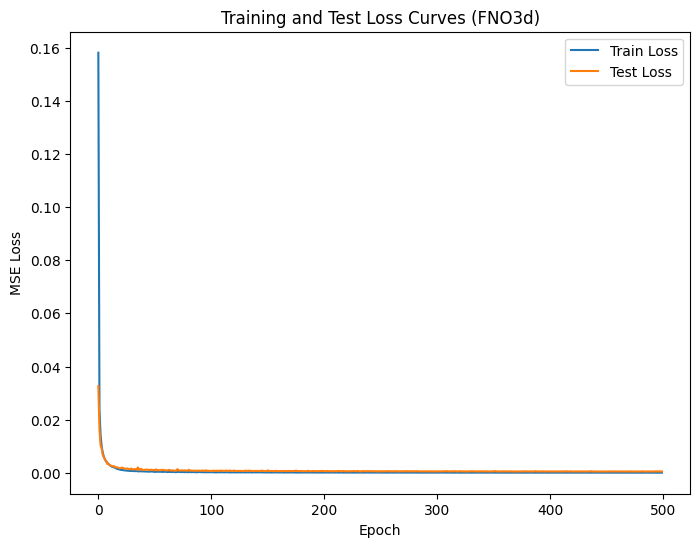

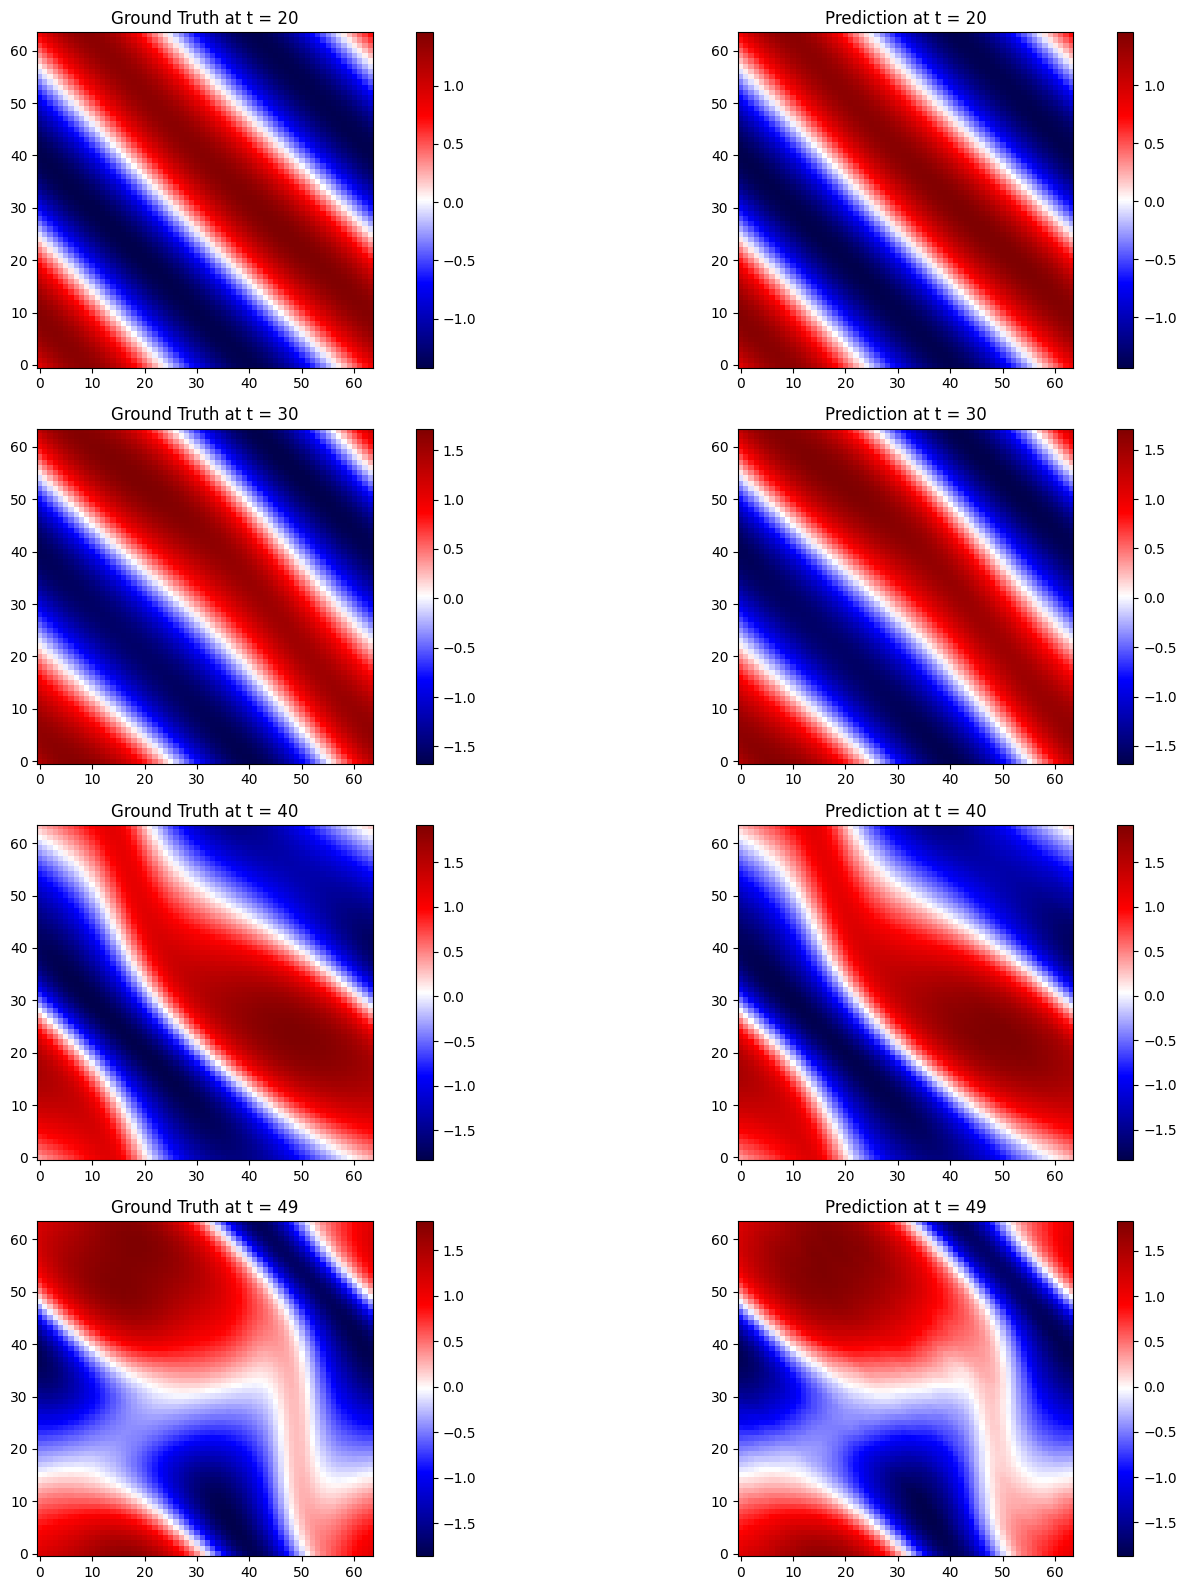

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    2D Navier–Stokes vorticity PDE (주기적 경계조건) 를 푸는 간단한 pseudo-spectral solver.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x),   and   ∆ψ = -w,  with periodic boundary conditions.
    입력:
        w0: 초기 vorticity, shape (N, N)
        nu: 점성 계수
        dt: 시간 스텝
        t_final: 최종 시간
        N: 격자 크기 (N×N)
    출력:
        snapshots: 정수 시간마다 (t, w) 튜플 리스트.
    """
    # 공간 좌표 생성 (0 ≤ x,y < 1)
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    
    # forcing function: f(x) = 0.1*( sin(2π(x+y)) + cos(2π(x+y)) )
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    
    # FFT frequencies (주기적 도메인: [0,1])
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0  # 0분할 방지
    
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)  # 정수 시간마다 기록
    next_snapshot_index = 0
    
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        # 스냅샷 기록
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        
        # vorticity의 FFT
        w_hat = np.fft.fft2(w)
        # stream function: ∆ψ = -w  ->  ψ_hat = -w_hat / ksq, ψ_hat(0)=0
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        
        # 속도 계산: u = ψ_y, v = -ψ_x (spectral differentiation)
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        
        # vorticity gradient (spectral differentiation)
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        
        # 비선형 항: u * w_x + v * w_y
        nonlinear = u * w_x + v * w_y
        
        # Laplacian: ∆w = ifft2(-ksq * w_hat)
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        
        # Euler explicit time stepping
        w = w + dt * (-nonlinear + nu * lap_w + f)
    
    return snapshots

    
# =============================================================================
# 2. Navier-Stokes 데이터셋 (PDE solver를 사용하여 데이터 생성)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        """
        num_samples: 샘플 개수.
        N: 공간 격자 크기 (N×N).
        dt: 시간 스텝.
        t_final: 최종 시각 (예, 30).
        nu: 점성 계수.
        T_in_range: 입력 시간 구간 (예: (0, 10)).
        T_out_times: 타겟 시간 (예: [15, 20, 25, 30]).
        """
        self.samples = []
        for i in range(num_samples):
            # 랜덤 초기 조건 (예: 가우시안 랜덤 필드)
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            # snapshots: [(t, w), ...] t는 정수 시간 (0,1,2,...,t_final)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # shape: (T_in, N, N)
            
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # shape: (T_out, N, N)
            self.samples.append((input_series, target_series))
        
        # 공간 좌표 (x, y) 생성, x,y ∈ [0,1)
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        # 입력 시간 좌표: 정수 시간 (예: 0,1,...,10)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        # 각 입력 시간(t)에 대해 [vorticity, t, x, y]를 결합
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # shape: (T_in, N, N, 4)
        
        # target_series의 길이가 기대하는 T_out와 같지 않은 경우, 부족한 부분을 마지막 스냅샷으로 패딩
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # shape: (T_out, N, N, 1)
        
        # Torch tensor로 변환
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data


# =============================================================================
# 3. 기존의 FNO 모델 (3D FNO: 시간-공간 연산자 학습)
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        # 기존 weight
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
        # 각 모드에 대해 학습 가능한 마스크 파라미터 (초기값 1로 설정)
        # 마스크는 [0,1] 범위로 제한하기 위해 sigmoid를 적용할 수 있음.
        self.mask = nn.Parameter(torch.ones(modes_t, modes_x, modes_y))
    
    def compl_mul3d(self, input, weights):
        weight_complex = torch.view_as_complex(weights)
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        # 마스크에 sigmoid를 적용하여 0~1 범위로 제한 (또는 ReLU 등 다른 함수 사용 가능)
        mask = torch.sigmoid(self.mask)
        # mask의 shape을 weight와 맞춰줍니다.
        mask = mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1)  # shape: (1, 1, modes_t, modes_x, modes_y, 1)
        # 효과적인 weight 계산: 학습된 weight와 mask를 element-wise 곱함
        effective_weights = self.weights * mask
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            effective_weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x



class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out):
        """
        modes_t, modes_x, modes_y: 시간 및 공간 방향의 Fourier 모드 수.
        width: latent channel 차원.
        T_in: 입력 시간 스텝 수 (예: 11, t=0~10)
        T_out: 출력 시간 스텝 수 (예: 4, t=15,20,25,30)
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # 입력 채널: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # 출력: vorticity
        
        # Temporal predictor: 각 픽셀별로 입력 시간(T_in)을 출력 시간(T_out)으로 매핑
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: 각 픽셀별로 입력 시간 차원(T_in)을 T_out 차원으로 변환
        x = x.squeeze(-1)              # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)        # (batch, H, W, T_in)
        x = self.temporal_fc(x)          # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x


# =============================================================================
# 4. 학습 루프 및 시각화
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for input_data, target in train_loader:
            # input_data: (batch, T_in, H, W, 4), target: (batch, T_out, H, W, 1)
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * input_data.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss = loss_fn(output, target)
                test_loss += loss.item() * input_data.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        #scheduler.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
    
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Test Loss Curves (FNO3d)")
    plt.show()
    
    return train_losses, test_losses

def visualize_sample_3d(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)
    sample_target = target[0].cpu().numpy()  # (T_out, H, W, 1)
    sample_pred = pred[0].cpu().numpy()      # (T_out, H, W, 1)
    times = [t1, t2, t3, t4]  # target 시간 라벨
    T_out = sample_target.shape[0]
    plt.figure(figsize=(16, 4*T_out))
    for i in range(T_out):
        plt.subplot(T_out, 2, 2*i+1)
        plt.title(f"Ground Truth at t = {times[i]}")
        plt.imshow(sample_target[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
        plt.subplot(T_out, 2, 2*i+2)
        plt.title(f"Prediction at t = {times[i]}")
        plt.imshow(sample_pred[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 5. 전체 파이프라인 실행
# =============================================================================
if __name__ == '__main__':
    # PDE simulation parameters
    N = 64         # spatial resolution: 64x64
    dt = 0.005     # 시간 스텝 (안정성을 위해 충분히 작게)
    t_final = 50   # 최종 시각
    nu = 1e-3      # 점성 계수 (예시)
    
    # 데이터셋에서 사용할 시간 구간
    T_in_range = (0, 10)          # 입력: t=0 ~ 10 (정수 시간 스냅샷)
    t1, t2, t3, t4 = 20, 30, 40, 49
    T_out_times = [t1, t2, t3, t4] # 타겟: t = 15,20,25,30
    
    num_train = 1000   # 시연을 위한 샘플 수 (실제 연구에서는 더 많은 샘플 사용)
    num_test = 200
    
    # Navier–Stokes PDE solver를 통해 데이터 생성
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    # 모델 하이퍼파라미터: Fourier 모드 수 선택 (시간: 4, x: 16, y: 16), width: 32, T_out: 4
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = 11
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out)
    
    # 학습
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=500)
    
    # 결과 시각화
    visualize_sample_3d(model, test_loader)

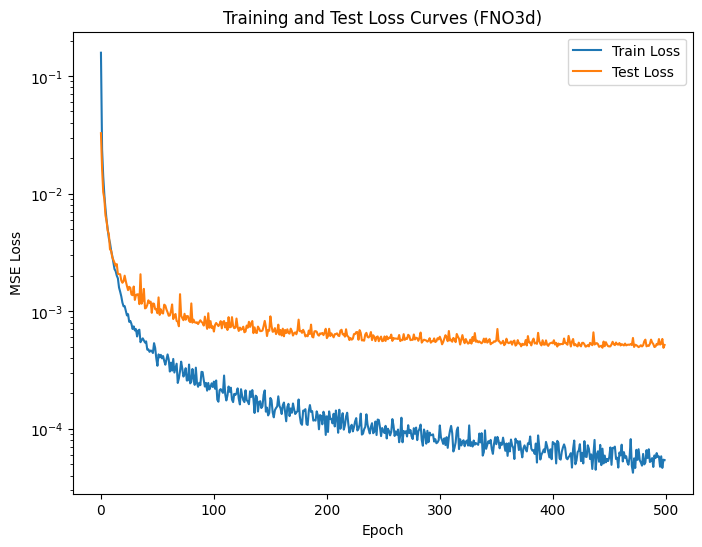

In [7]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Test Loss Curves (FNO3d)")
plt.show()